<a href="https://colab.research.google.com/github/AyanS13/random_stuff/blob/main/K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering: From Scratch to Evaluation

K-Means is an unsupervised learning algorithm that partitions data into $K$ clusters. This notebook demonstrates the implementation of the algorithm, the **Elbow Method**, and the **Silhouette Score** using only NumPy.

### The Algorithm Logic:
1. **Initialization**: Pick $K$ random points as centroids.
2. **Assignment**: Assign each data point to the nearest centroid using Euclidean distance:
   $$d(x, c) = \sqrt{\sum_{i=1}^{n} (x_i - c_i)^2}$$
3. **Update**: Move centroids to the mean of all points assigned to them.
4. **Repeat**: Until centroids stabilize (convergence).

### Evaluation Metrics:
* **Inertia (WCSS)**: Sum of squared distances of samples to their closest cluster center. Lower is better.
* **Silhouette Score**: Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
    $$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$
    *Range: [-1, 1]. Higher is better.*

K     Inertia         Silhouette Score
----------------------------------------
2     2646.68         0.5235
3     2234.34         0.4509
4     272.85          0.7154
5     247.43          0.6092
6     224.00          0.5792
7     208.74          0.5781


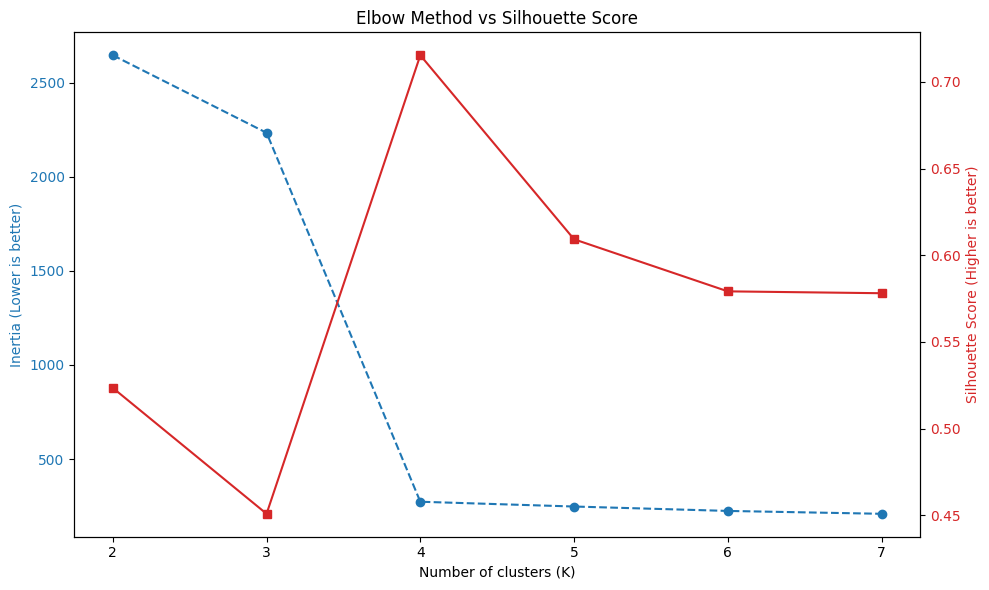

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Generation ---
def generate_blobs(n_samples=300, centers=4, cluster_std=0.60):
    np.random.seed(42)
    data = []
    true_centroids = np.random.uniform(-5, 5, size=(centers, 2))
    for i in range(centers):
        points = np.random.randn(n_samples // centers, 2) * cluster_std + true_centroids[i]
        data.append(points)
    return np.vstack(data)

# --- 2. Silhouette Score from Scratch ---
def silhouette_score_scratch(X, labels):
    """
    Calculates the mean Silhouette Coefficient for the dataset.
    This is computationally expensive O(N^2), so use with small datasets (N < 2000).
    """
    n_samples = len(X)
    unique_labels = np.unique(labels)

    # If only 1 cluster exists, silhouette is not defined (return 0)
    if len(unique_labels) < 2:
        return 0

    s_values = []

    # Pre-calculate distance matrix for speed (Vectorized)
    # diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    # dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))

    # Using a simple loop for clarity instead of giant matrix memory usage
    for i in range(n_samples):
        point = X[i]
        label = labels[i]

        # 1. Calculate a(i): Average distance to own cluster
        own_cluster_points = X[labels == label]

        # If the cluster has only 1 point, a(i) is 0
        if len(own_cluster_points) == 1:
            a_i = 0
        else:
            # Distance to all other points in same cluster
            a_distances = np.sqrt(np.sum((own_cluster_points - point)**2, axis=1))
            a_i = np.mean(a_distances)

        # 2. Calculate b(i): Average distance to nearest neighbor cluster
        b_i = np.inf

        for other_label in unique_labels:
            if other_label == label:
                continue

            other_cluster_points = X[labels == other_label]
            b_distances = np.sqrt(np.sum((other_cluster_points - point)**2, axis=1))
            mean_dist = np.mean(b_distances)

            if mean_dist < b_i:
                b_i = mean_dist

        # 3. Calculate s(i)
        s_i = (b_i - a_i) / max(a_i, b_i)
        s_values.append(s_i)

    return np.mean(s_values)

# --- 3. K-Means Class ---
class KMeansScratch:
    def __init__(self, k=3, max_iters=100, tolerance=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.centroids = None
        self.inertia_ = 0

    def fit(self, X):
        indices = np.random.choice(len(X), self.k, replace=False)
        self.centroids = X[indices]

        for _ in range(self.max_iters):
            distances = self._calc_distances(X)
            labels = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.zeros_like(self.centroids)
            for i in range(self.k):
                points_in_cluster = X[labels == i]
                if len(points_in_cluster) > 0:
                    new_centroids[i] = points_in_cluster.mean(axis=0)
                else:
                    new_centroids[i] = self.centroids[i] # Keep old if empty

            if np.all(np.abs(new_centroids - self.centroids) < self.tolerance):
                self.centroids = new_centroids
                break
            self.centroids = new_centroids

        # Final Inertia
        final_distances = self._calc_distances(X)
        self.inertia_ = np.sum(np.min(final_distances, axis=1) ** 2)
        return labels # Return labels for Silhouette calculation

    def _calc_distances(self, X):
        return np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))

# --- 4. Main Execution ---
# Generate data with 4 true centers
X = generate_blobs(n_samples=300, centers=4, cluster_std=0.7)

inertias = []
silhouette_scores = []
k_range = range(2, 8) # Silhouette needs at least 2 clusters

print(f"{'K':<5} {'Inertia':<15} {'Silhouette Score'}")
print("-" * 40)

for k in k_range:
    km = KMeansScratch(k=k)
    labels = km.fit(X)

    inertias.append(km.inertia_)

    # Calculate Silhouette
    score = silhouette_score_scratch(X, labels)
    silhouette_scores.append(score)

    print(f"{k:<5} {km.inertia_:<15.2f} {score:.4f}")

# --- 5. Visualization ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Inertia (The Elbow)
color = 'tab:blue'
ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('Inertia (Lower is better)', color=color)
ax1.plot(k_range, inertias, 'o--', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Silhouette
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score (Higher is better)', color=color)
ax2.plot(k_range, silhouette_scores, 's-', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method vs Silhouette Score')
fig.tight_layout()
plt.show()

### Observations:
1.  **Elbow Point**: Look for where the blue line steepness decreases significantly.
2.  **Silhouette Peak**: The highest point on the red line represents the most distinct clustering.
3.  **Pros of K-Means**: Simple, fast, and scales well.
4.  **Cons**: Sensitive to initialization and outliers; requires $K$ to be specified.



## K-Means with Scikit-Learn

While the manual implementation is great for understanding, the `scikit-learn` version offers several production-grade improvements:
1. **K-means++**: A smarter initialization technique that spreads out initial centroids to avoid poor local optima.
2. **Standardization**: Using `StandardScaler` to ensure all features contribute equally to distance calculations.
3. **Optimized Performance**: Highly efficient C-based implementation.

Final Inertia: 32.78
Silhouette Score: 0.7182


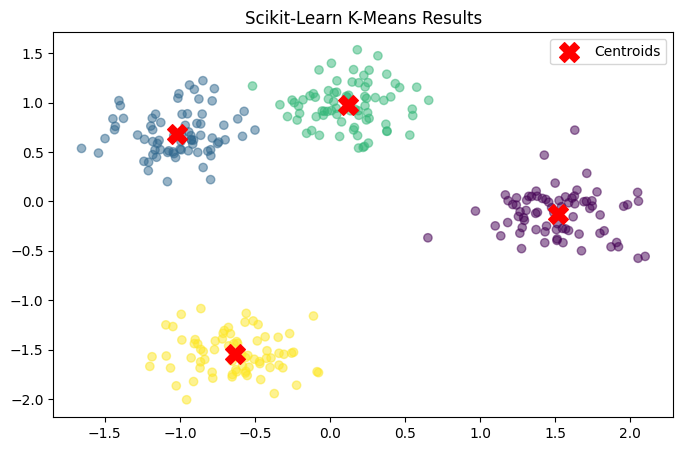

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. Scale the data
# (Even though our synthetic data is balanced, this is best practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Define the model
# n_init='auto' or 10 ensures the algorithm runs multiple times with
# different seeds to find the best global result.
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)

# 3. Fit and Predict
labels_sklearn = kmeans.fit_predict(X_scaled)
centroids_sklearn = kmeans.cluster_centers_

# 4. Evaluate
print(f"Final Inertia: {kmeans.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, labels_sklearn):.4f}")

# 5. Visualize Results
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sklearn, cmap='viridis', alpha=0.5)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title("Scikit-Learn K-Means Results")
plt.legend()
plt.show()

## Handling Outliers

K-Means is highly sensitive to outliers because it uses the arithmetic mean. Outliers can:
1. Distort the centroid locations.
2. Artificially inflate the Inertia.
3. Force clusters to merge or split incorrectly.

### The IQR Method
We can define outliers as any point that falls outside the range:
$$[Q1 - 1.5 \times IQR, Q3 + 1.5 \times IQR]$$
where $IQR = Q3 - Q1$.

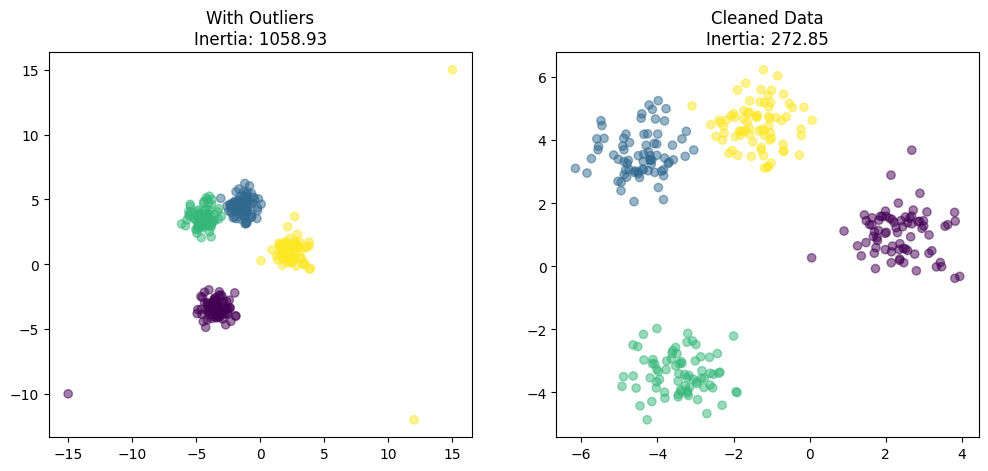

In [5]:
def remove_outliers(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only data within the bounds for both dimensions
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask]

# 1. Generate data with a few extreme outliers
X_outliers = np.vstack([X, [[15, 15], [-15, -10], [12, -12]]])

# 2. Clean the data
X_cleaned = remove_outliers(X_outliers)

# 3. Compare Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Dirty Data
km_dirty = KMeans(n_clusters=4, n_init='auto').fit(X_outliers)
ax1.scatter(X_outliers[:,0], X_outliers[:,1], c=km_dirty.labels_, alpha=0.5)
ax1.set_title(f"With Outliers\nInertia: {km_dirty.inertia_:.2f}")

# Cleaned Data
km_clean = KMeans(n_clusters=4, n_init='auto').fit(X_cleaned)
ax2.scatter(X_cleaned[:,0], X_cleaned[:,1], c=km_clean.labels_, alpha=0.5)
ax2.set_title(f"Cleaned Data\nInertia: {km_clean.inertia_:.2f}")

plt.show()